In [1]:
%matplotlib inline
import os
import torch
import SimpleITK as sitk

# --- Download Trained Model Weights (~400MB) ---
REPO_ID = "nnInteractive/nnInteractive"
MODEL_NAME = "nnInteractive_v1.0"  # Updated models may be available in the future
DOWNLOAD_DIR = "/nfs/norasys/notebooks/camaret/model_checkpoints"  # Specify the download directory
IMAGE_FILENAME = "/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/amos22/amos22/imagesVa/amos_0311.nii.gz"  # Specify the input image filename



In [2]:

# --- Initialize Inference Session ---
from nnInteractive.inference.inference_session import nnInteractiveInferenceSession
 
session = nnInteractiveInferenceSession(
    device=torch.device("cuda:0"),  # Set inference device
    use_torch_compile=False,  # Experimental: Not tested yet
    verbose=False,
    torch_n_threads=os.cpu_count(),  # Use available CPU cores
    do_autozoom=True,  # Enables AutoZoom for better patching
    use_pinned_memory=True,  # Optimizes GPU memory transfers
)

# Load the trained model
model_path = os.path.join(DOWNLOAD_DIR, MODEL_NAME)
session.initialize_from_trained_model_folder(model_path)



nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [3]:
# --- Load Input Image (Example with SimpleITK) ---
import nibabel as nib
import matplotlib.pyplot as plt

input_image = sitk.ReadImage(IMAGE_FILENAME)
img = sitk.GetArrayFromImage(input_image)[None]  # Ensure shape (1, x, y, z)


img.shape

(1, 198, 512, 512)

In [4]:
import numpy as np
def resize_array(arr, target_shape):
    """Resize array to target_shape by center cropping/padding.
    Works with any number of dimensions."""
    
    # Create empty result array
    result = np.zeros(target_shape, dtype=arr.dtype)
    
    # Create slices for both arrays
    slices_orig = []
    slices_result = []
    
    for i in range(len(target_shape)):
        # How much to take from original
        size = min(arr.shape[i], target_shape[i])
        # Start index for original (center crop)
        start_orig = (arr.shape[i] - size) // 2
        # Start index for result (center pad)
        start_result = (target_shape[i] - size) // 2
        
        slices_orig.append(slice(start_orig, start_orig + size))
        slices_result.append(slice(start_result, start_result + size))
    
    # Copy the data
    result[tuple(slices_result)] = arr[tuple(slices_orig)]
    
    return result

# Usage example
reshaped_img = resize_array(img, (1, 64, 128, 128))
print(f"Original shape: {img.shape}, New shape: {reshaped_img.shape}")

Original shape: (1, 198, 512, 512), New shape: (1, 64, 128, 128)


In [5]:
from scipy.ndimage import zoom

def resize_preserve_content(arr, target_shape):
    """Resize array to target shape using interpolation to preserve all content."""
    # Calculate zoom factors for each dimension
    factors = [t/s for t, s in zip(target_shape, arr.shape)]
    
    # Apply zoom with interpolation
    return zoom(arr, factors, order=1)

# Usage
reshaped_img = resize_preserve_content(img, (1, 64, 128, 128))
print(f"Original shape: {img.shape}, New shape: {reshaped_img.shape}")

Original shape: (1, 198, 512, 512), New shape: (1, 64, 128, 128)


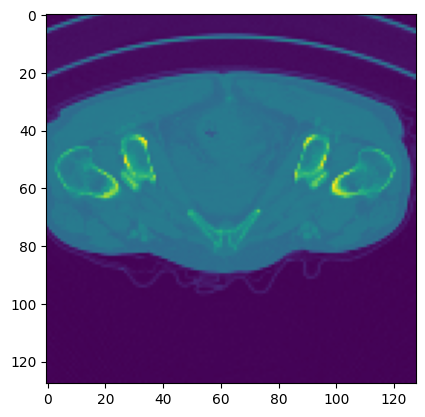

In [6]:
import matplotlib
matplotlib.use('inline')
plt.imshow(reshaped_img[0, 3, :, :])

In [7]:
img = reshaped_img

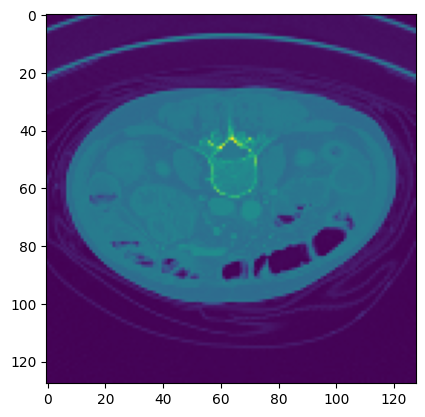

In [8]:
# Or explicitly set a backend
import matplotlib
matplotlib.use('inline')
plt.imshow(img[0, 30, :, :])

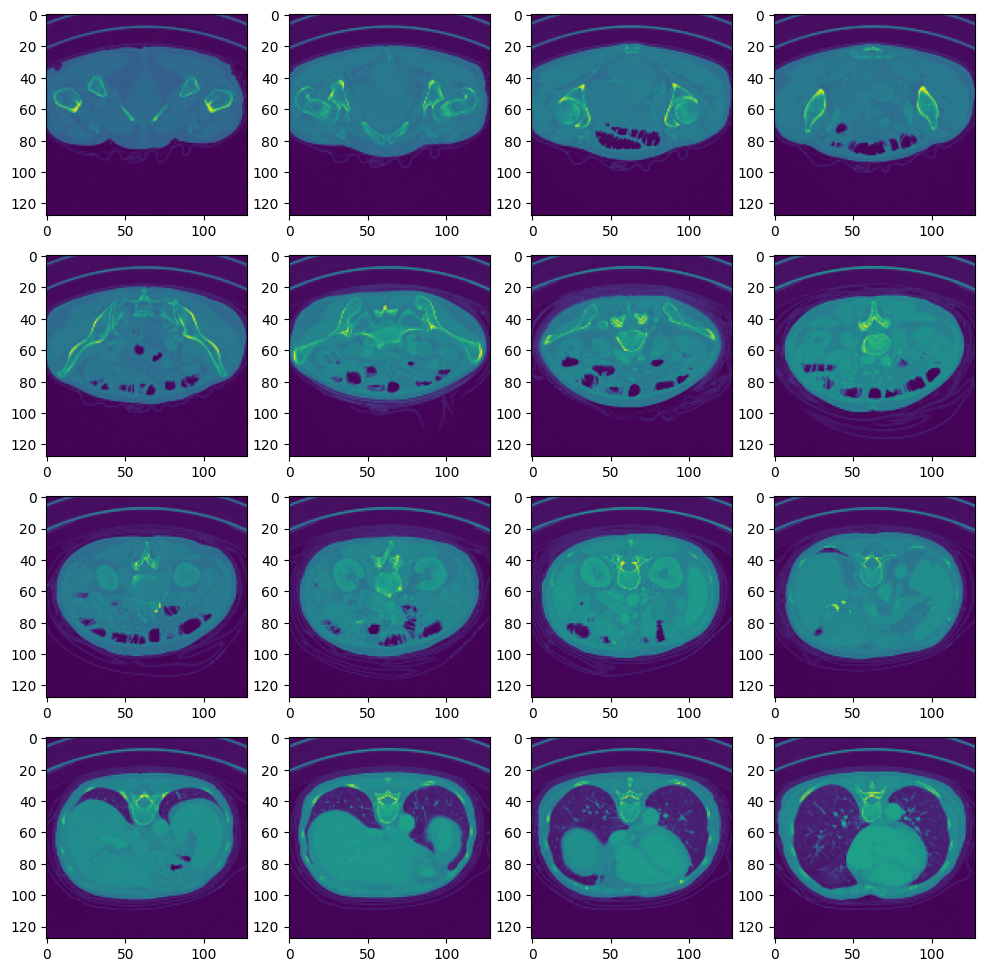

In [9]:
plt.style.use("default")
fig,axes = plt.subplots(4,4, figsize =(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[0,4*i,:,:])
plt.show()

In [15]:

# Validate input dimensions
if img.ndim != 4:
    raise ValueError("Input image must be 4D with shape (1, x, y, z)")

session.set_image(img)

# --- Define Output Buffer ---
target_tensor = torch.zeros(img.shape[1:], dtype=torch.uint8)  # Must be 3D (x, y, z)
session.set_target_buffer(target_tensor)

# --- Interacting with the Model ---
# Interactions can be freely chained and mixed in any order. Each interaction refines the segmentation.
# The model updates the segmentation mask in the target buffer after every interaction.

# Example: Add a point interaction
# POINT_COORDINATES should be a tuple (x, y, z) specifying the point location.
POINT_COORDINATES = (60, 50, 30)  # Example point at (50, 50, 10)
session.add_point_interaction(POINT_COORDINATES, include_interaction=True)

# Example: Add a bounding box interaction
# BBOX_COORDINATES must be specified as [[x1, x2], [y1, y2], [z1, z2]] (half-open intervals).
# Note: nnInteractive pre-trained models currently only support **2D bounding boxes**.
# This means that **one dimension must be [d, d+1]** to indicate a single slice.


# Example of a 2D bounding box in the axial plane (XY slice at depth Z)
BBOX_COORDINATES = [[30, 80], [40, 100], [10, 11]]  # X: 30-80, Y: 40-100, Z: slice 10

# session.add_bbox_interaction(BBOX_COORDINATES, include_interaction=True)

# Example: Add a scribble interaction
# - A 3D image of the same shape as img where one slice (any axis-aligned orientation) contains a hand-drawn scribble.
# - Background must be 0, and scribble must be 1.
# - Use session.preferred_scribble_thickness for optimal results.
# session.add_scribble_interaction(SCRIBBLE_IMAGE, include_interaction=True)

# Example: Add a lasso interaction
# - Similarly to scribble a 3D image with a single slice containing a **closed contour** representing the selection.
# session.add_lasso_interaction(LASSO_IMAGE, include_interaction=True)

# You can combine any number of interactions as needed. 
# The model refines the segmentation result incrementally with each new interaction.

# --- Retrieve Results ---
# The target buffer holds the segmentation result.
results = session.target_buffer.clone()
# OR (equivalent)
results = target_tensor.clone()

# Cloning is required because the buffer will be **reused** for the next object.
# Alternatively, set a new target buffer for each object:
session.set_target_buffer(torch.zeros(img.shape[1:], dtype=torch.uint8))

# --- Start a New Object Segmentation ---
session.reset_interactions()  # Clears the target buffer and resets interactions

# Now you can start segmenting the next object in the image.

# --- Set a New Image ---
# Setting a new image also requires setting a new matching target buffer
"""
session.set_image(NEW_IMAGE)
session.set_target_buffer(torch.zeros(NEW_IMAGE.shape[1:], dtype=torch.uint8))
"""
# Enjoy!

Added new point interaction: center 1, scale [[60, 50, 30]]
Performing prediction at zoom out factor 1
Auto zoom stage took 0.466s. Max zoom out factor was 1
No refinement necessary
Done. Total time 0.467s


'\nsession.set_image(NEW_IMAGE)\nsession.set_target_buffer(torch.zeros(NEW_IMAGE.shape[1:], dtype=torch.uint8))\n'

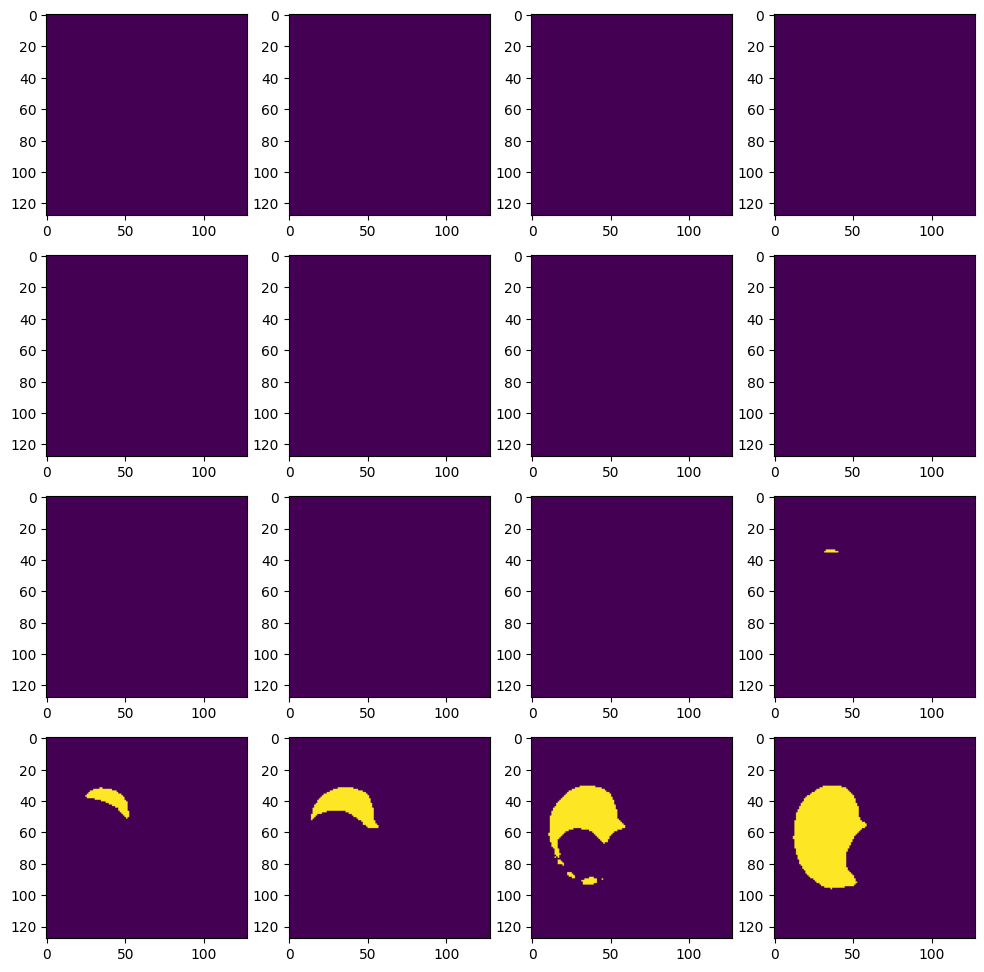

In [16]:
plt.style.use("default")
fig,axes = plt.subplots(4,4, figsize =(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(results[4*i,:,:])
plt.show()

In [ ]:
img.resize(64, 128, 128)